In [1]:
import urllib
import pickle
import pandas as pd
import enum

import dateparser

from human_accuracy import *
import plotter

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [109]:
%time data_bytes = urllib.request.urlopen("https://pictureweb.s3-us-west-2.amazonaws.com/human_accuracy.pickle").read()

CPU times: user 1.19 s, sys: 1.33 s, total: 2.53 s
Wall time: 1min 34s


In [127]:
ha_data = pickle.loads(data_bytes)
def load_ha(ha_data):
    return HumanAccuracyPortable(annot_data=ha_data["annot_data"], 
                                 labeled_images=ha_data["labeled_images"], 
                                 image_labels=ha_data["image_labels"],
                                 split_wnids=ha_data["split_wnids"],
                                 image_map=ha_data["image_map"],
                                 all_candidates=ha_data["all_candidates"],
                                 wnid_map=ha_data["wnid_map"])

In [142]:
h_a = load_ha(ha_data)

In [143]:
len(h_a.labeled_images)

2000

In [144]:
all_data = []
for user in h_a.annot_data.keys():
    try:
        all_data.append(compute_acc_dict(h_a, user, extra_filters=[], top1=False))
    except KeyError as e:
        pass

In [145]:
df = pd.DataFrame(all_data, columns=["username", "val", "v2"])


In [146]:
class ModelTypes(enum.Enum):
    MODEL = ('Model trained on ImageNet', 'tab:blue', 150)
    MODELPLUS = ('Model trained on more data', 'tab:red', 150)
    HUMAN = ('Human labelers', 'tab:green', 150)
    HUMAN_ENSEMBLE = ('Human Ensemble', 'tab:purple', 150)

In [147]:
def get_user_type(df_row):
    user_name = df_row.username.lower()
    MODELSPLUS = ["fixresnext101_32x48d_v2", "instagram-48d"]
    if user_name == "human_majority":
        return ModelTypes.HUMAN_ENSEMBLE
    elif "human" in user_name:
        return ModelTypes.HUMAN
    elif user_name in MODELSPLUS:
        return ModelTypes.MODELPLUS
    else:
        return ModelTypes.MODEL

def add_dataset_size(df_row):

    if df_row.dataset == "v2":
        return v2_size
    elif df_row.dataset == "val":
        return val_size
    else:
        assert False
        
def show_in_plot(df_row):
    if "fv" not in df_row.username and df_row.val > 70 and df_row.username != "model_majority" and df_row.username != "instagram_model_48d":
        return True
    
def use_for_line_fit(df_row):
    user_name = df_row.username.lower()
    return "human" not in user_name

In [148]:
val_size = len([x for x in h_a.labeled_images if x not in h_a.all_candidates and not h_a._image_map[x]["problematic"]])
v2_size = len([x for x in h_a.labeled_images if x in h_a.all_candidates and not h_a._image_map[x]["problematic"]])
df['model_type'] = df.apply(get_user_type, axis=1)
df['v2_dataset_size'] =  v2_size
df['val_dataset_size'] = val_size
df['show_in_plot'] = df.apply(show_in_plot, axis=1) 
df['use_for_line_fit'] = df.apply(use_for_line_fit, axis=1)

In [149]:
df

,username,val,v2,model_type,v2_dataset_size,val_dataset_size,show_in_plot,use_for_line_fit
0,instagram_model_48d,94.00,88.57,ModelTypes.MODEL,980,984,None,True
1,efficientnet-b7,92.89,85.71,ModelTypes.MODEL,980,984,True,True
2,resnet50,84.15,75.71,ModelTypes.MODEL,980,984,True,True
3,dpn98,88.11,80.10,ModelTypes.MODEL,980,984,True,True
4,inceptionresnetv2,89.23,82.96,ModelTypes.MODEL,980,984,True,True
5,human_majority,97.15,97.45,ModelTypes.HUMAN_ENSEMBLE,980,984,True,False
6,se_resnet50,85.57,79.39,ModelTypes.MODEL,980,984,True,True
7,dpn68b,84.25,76.12,ModelTypes.MODEL,980,984,True,True
8,densenet121,83.13,75.00,ModelTypes.MODEL,980,984,True,True
9,inception_resnet_v2_tf,88.41,83.27,ModelTypes.MODEL,980,984,True,True


Include random chance:  False
ylim range / xlim range aspect ratio:  1.4343141317861576
ymax 89.59
Slope 1.05109974393571, intercept -12.158672510554425, r 0.993680148664137, pvalue 3.469944667257603e-69, stderr 0.014091243368546627


Text(68.875, 0.5, 'Top-1 Accuracy on ImageNetV2')

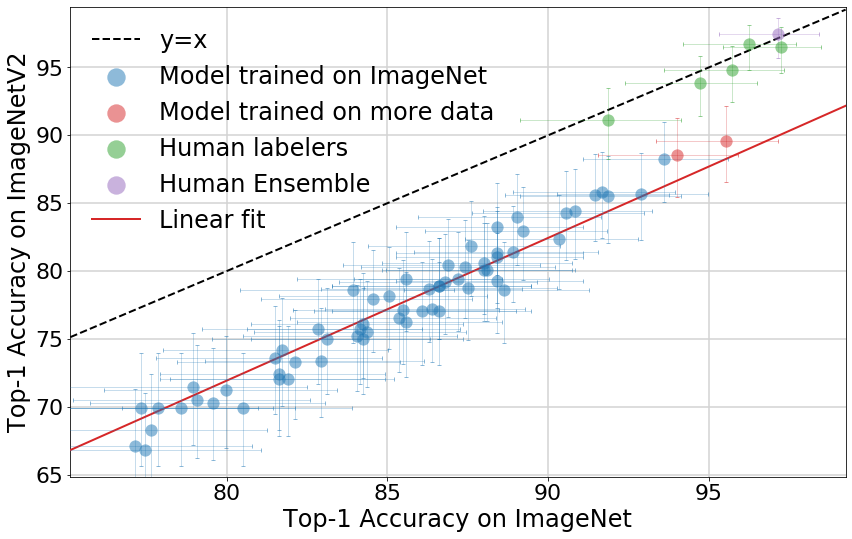

In [150]:
x_axis, y_axis = 'val', 'v2'
df1 = df.copy()
df1 = plotter.add_plotting_data(df1, [x_axis, y_axis])

# auto set xlim and ylim based on visible points
df_visible = df1[df1.show_in_plot == True]
xlim = [df_visible[x_axis].min() - 2, df_visible[x_axis].max() + 2]
ylim = [df_visible[y_axis].min() - 2, df_visible[[x_axis, y_axis]].values.max() +2]
fig, _ = plotter.model_scatter_plot(df1, x_axis, y_axis, xlim, ylim, ModelTypes, 
                                            num_bootstrap_samples=10, transform='linear', tick_multiplier=5, title = '',
                                            x_label='ImageNet', y_label='ImageNetV2', 
                                            figsize=(12, 8), include_legend=True, return_separate_legend=False)
plt.title("")
plt.xlabel("Top-1 Accuracy on ImageNet")
plt.ylabel("Top-1 Accuracy on ImageNetV2")

Include random chance:  False
ylim range / xlim range aspect ratio:  1.5007476051293316
ymax 89.13793103448275
Slope 1.0617192918552096, intercept -14.235978907989619, r 0.9864057964839461, pvalue 1.977119737358106e-57, stderr 0.020991128600527688
human_a 97.07903780068729 96.72413793103448
human_b 98.28178694158075 97.75862068965517
human_c 99.14089347079039 99.82758620689656
human_d 98.79725085910653 98.44827586206897
human_e 98.79725085910653 97.06896551724138
FixResNeXt101_32x48d_v2 95.01718213058419 89.13793103448275
instagram-48d 93.98625429553265 87.93103448275862
efficientnet-b7 92.43986254295532 84.48275862068965
resnet50 82.4742268041237 72.75862068965517
Include random chance:  False
ylim range / xlim range aspect ratio:  1.3947682890977113
ymax 90.98265895953757
Slope 1.0563443825839032, intercept -12.06239256286122, r 0.9933473535181668, pvalue 2.1335333284136695e-68, stderr 0.014533289631572315
human_a 94.22632794457274 93.41040462427745
human_b 96.88221709006929 95.95375

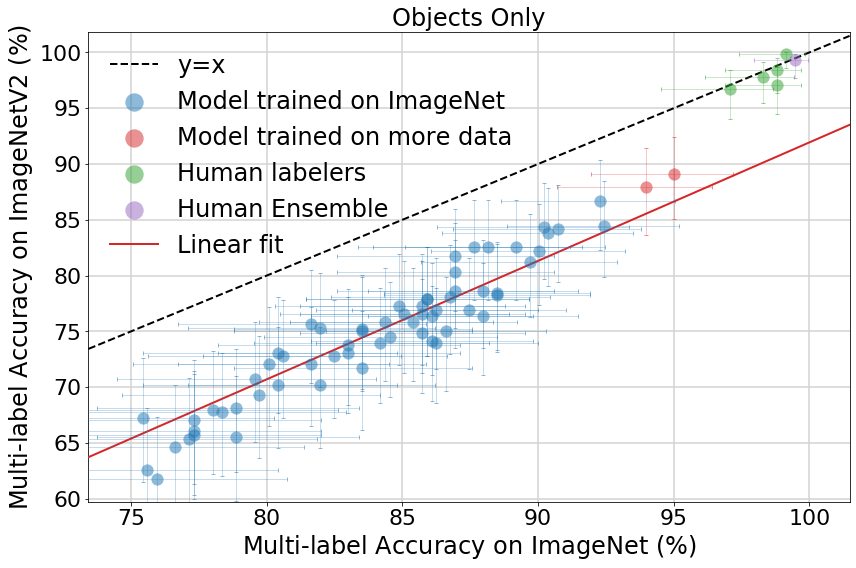

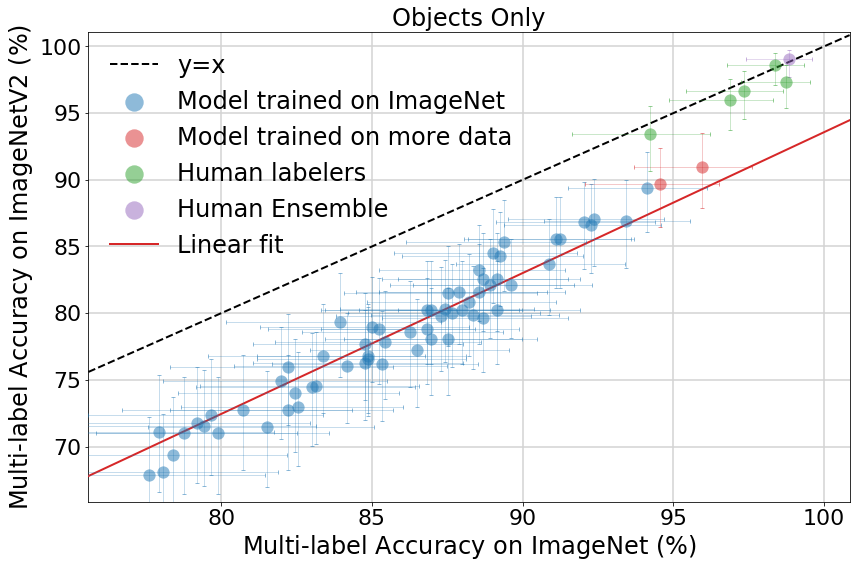

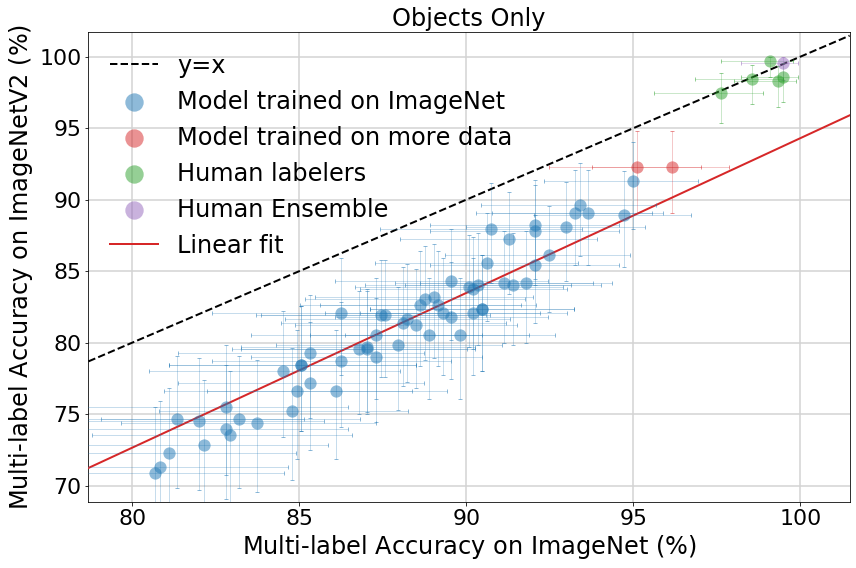

In [151]:
def subset_fig(filter_fn, fig_title):
    def filter_df_row(df_row):
        username = df_row['username']
        acc_val, num_img_filter_val = h_a.compute_accuracy(username, filters=[filter_fn, h_a.VAL_SET, h_a.NOT_PROBLEMATIC])
        acc_v2, num_img_filter_v2 = h_a.compute_accuracy(username, filters=[filter_fn, h_a.VTWO_SET, h_a.NOT_PROBLEMATIC])

        df_row['val'] = 100 * acc_val
        df_row['v2'] = 100 * acc_v2

        df_row['val_dataset_size'] = num_img_filter_val
        df_row['v2_dataset_size'] = num_img_filter_v2

        return df_row

    df_filter = df.copy()
    df_filter = df_filter.apply(filter_df_row, axis = 1)


    x_axis, y_axis = 'val', 'v2'

    df1 = plotter.add_plotting_data(df_filter, [x_axis, y_axis])

    # auto set xlim and ylim based on visible points
    df_visible = df1[df1.show_in_plot == True]
    xlim = [df_visible[x_axis].min() - 2, df_visible[x_axis].max() + 2]
    ylim = [df_visible[y_axis].min() - 2, df_visible[[x_axis, y_axis]].values.max() +2]
    fig, _ = plotter.model_scatter_plot(df1, x_axis, y_axis, xlim, ylim, ModelTypes, 
                                                num_bootstrap_samples=10, transform='linear', tick_multiplier=5,
                                                title=fig_title, x_label='ImageNet', y_label='ImageNetV2', 
                                                figsize=(12, 8), include_legend=True, return_separate_legend=False)

    table_users = ['human_a', 'human_b', 'human_c', 'human_d', 'human_e', 'FixResNeXt101_32x48d_v2', 
                   'instagram-48d', 'efficientnet-b7', 'resnet50']

    for user in table_users:
        print(user, float(df1.loc[df1['username'] == user]['val']), float(df1.loc[df1['username'] == user]['v2']))
        
subset_fig(h_a.OBJECT_FILTER, "objects_only")
subset_fig(h_a.NOTDOG_FILTER, "no_dogs")
subset_fig(h_a.FASTIMAGES_FILTER, "fast_images")